Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [6]:
NAME = "Barthélemy Paléologue"
COLLABORATORS = ""

---

# IN573-2021 Lab3 : Panorama Stitching

The goal of this lab is to develop a panorama creation pipeline from 2 images, using opencv functions. That is thus a higher level lab, where the goal is to check that
- you understood the lecture concepts
- you are able to find and use their implementation in the opencv library and to put in place the full pipeline.
The documentation is available at https://docs.opencv.org/master, mostly in the features2D and calib3d modules.

In [7]:
%matplotlib inline

import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 as cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


This `imshow` function is provided to display arrays of `images` with `titles`.
You can adjust the default `figsize` of (15,20) to your screen.

In [8]:

def imshow(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional


Here are 2 images, taken from the same position, with a small rotation of the viewing axis around a almost vertical rotation axis. 

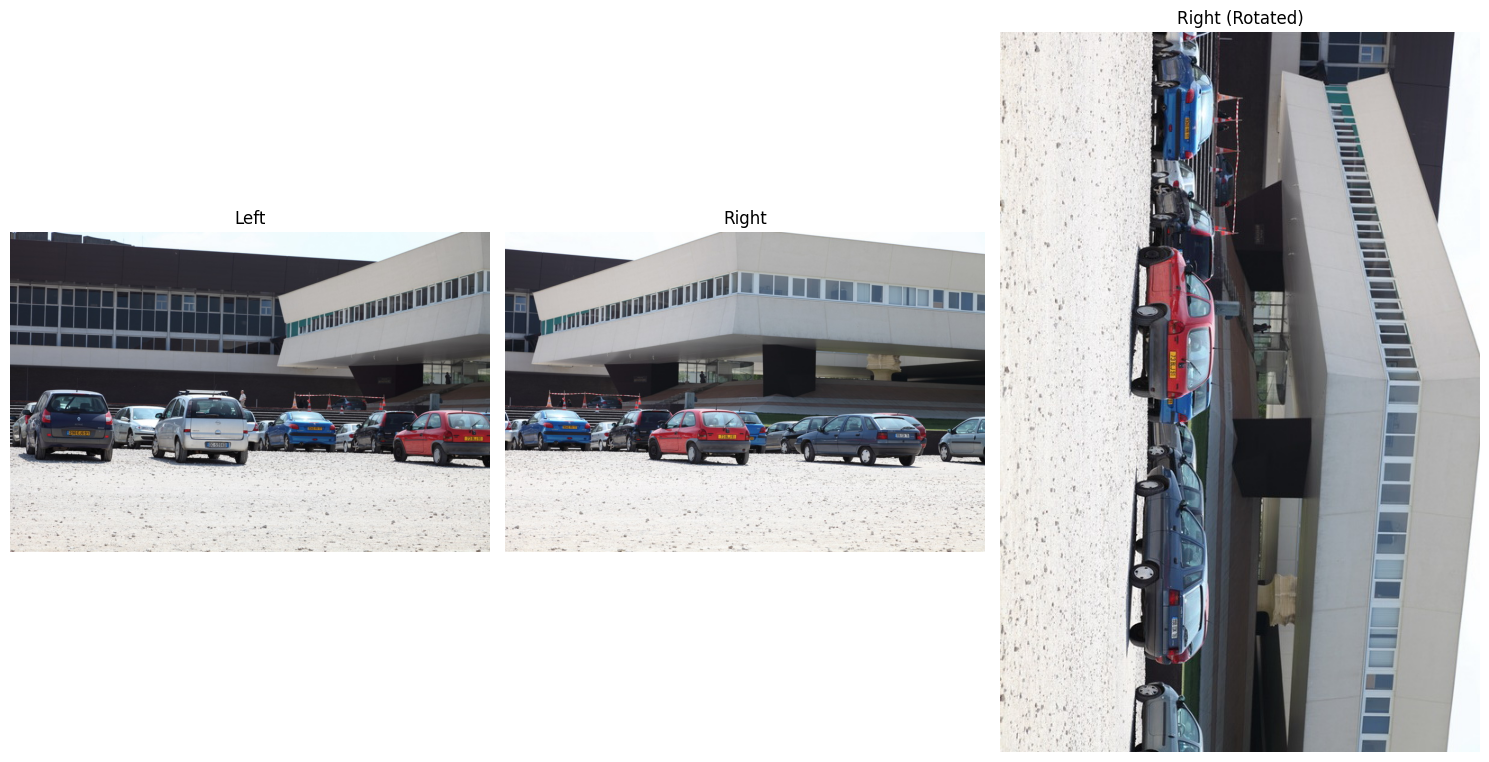

In [9]:
url1  = 'https://www.umr-lastig.fr/mathieu-bredif/data/IMG_0045.JPG'
url2  = 'https://www.umr-lastig.fr/mathieu-bredif/data/IMG_0046.JPG'
url2r = 'https://www.umr-lastig.fr/mathieu-bredif/data/IMG_0046r.JPG'
image1  = io.imread( url1 ) 
image2  = io.imread( url2 ) 
image2r = io.imread( url2r ) 
imshow( [image1, image2, image2r], ['Left', 'Right', 'Right (Rotated)'])
  

# Q0 Let's try a translation
It looks like the common parts of the left and right image are just differing by a translation.
Try to estimate the translation (tx, ty) that results in the least amount of seams in the resulting panorama.

Notice: You can get close, but a perfect alignment is impossible here with a translation only.

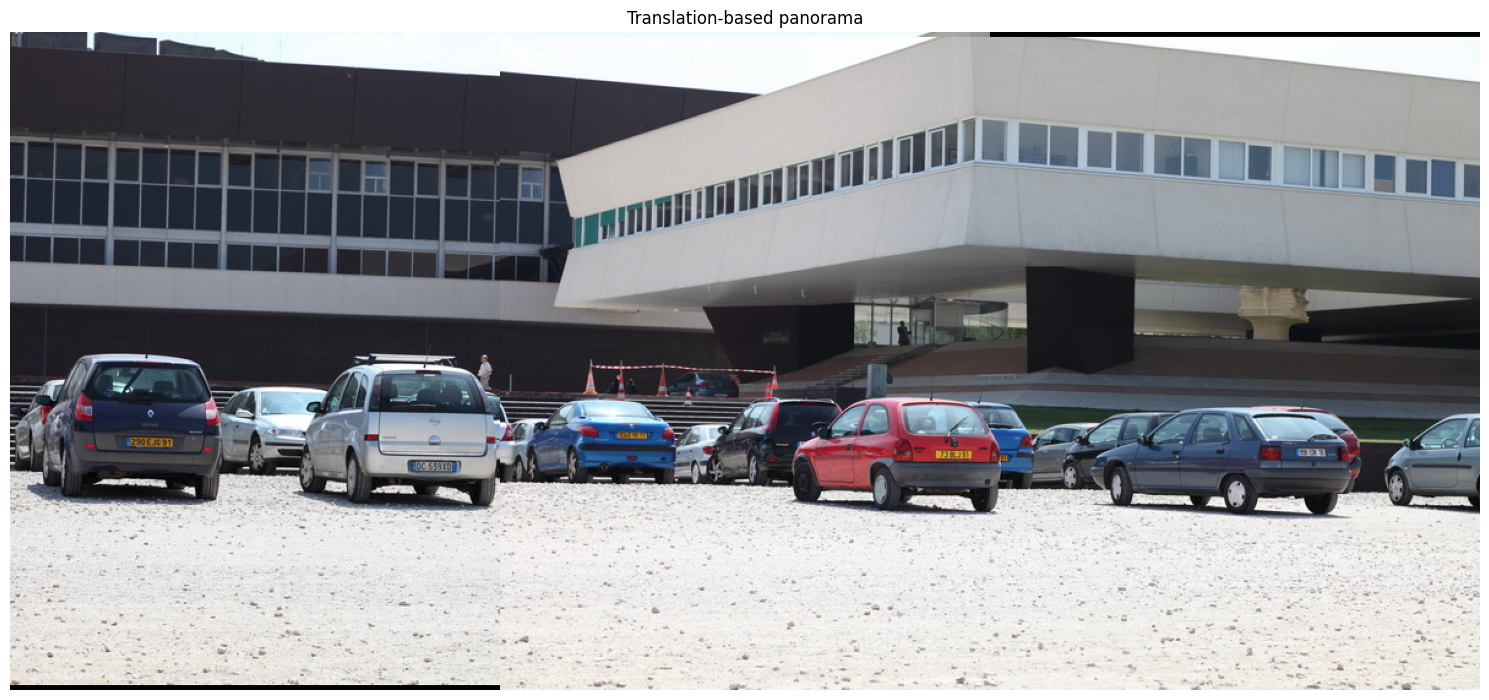

In [10]:
tx = 400
ty = 4
size = (ty+image2.shape[0], tx+image2.shape[1], 3)
image_trans = np.uint8(np.zeros(size))
image_trans[0:image1.shape[0], 0:image1.shape[1]] = image1
image_trans[ty:ty+image2.shape[0], tx:tx+image2.shape[1]] = image2 

imshow( [image_trans], ['Translation-based panorama'])

# Q1. Feature Extraction and Description
Use the AKAZE opencv feature extractor and descriptor to detect and compute features on both images.
You can access the key points coordinates using 

In [11]:
def extract_key_points(img1, img2):
    akaze = cv2.AKAZE_create()
    kp1, des1 = akaze.detectAndCompute(img1, None)
    kp2, des2 = akaze.detectAndCompute(img2, None)

    return kp1, des1, kp2, des2

kp1, des1, kp2, des2 = extract_key_points(image1, image2)


print("Coordinates of the first keypoint of image1: ", kp1[0].pt)
print("Descriptor of the first keypoint of image1:\n", des1[0])

Coordinates of the first keypoint of image1:  (599.1265869140625, 50.67598342895508)
Descriptor of the first keypoint of image1:
 [192   7  18  24   6   0 248 255  30 231 255   3   0 128 255   7  14 128
   7 240   0  15   0   0   0   0   0  12   0   0 255 241 127 220  15 251
 176 232 255 255 255 239   3 128  15  63   4 128   3 240   0  15  48   0
   0   0   0 248 255 255   1]


# Q2. Feature matching
Now you have to match the features between images. For this you need to use a descriptor matcher, which computes feature correspondences. Many matching strategy exist, let us use the simplest Brute Force approach here implemented in [BFMatcher](https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_feature2d/py_matcher/py_matcher.html). 

The quality of each match is measured in the distance property of the match. It may be interesting to sort the matches by increasing distance so that the first matches of the list are the more relevant. 

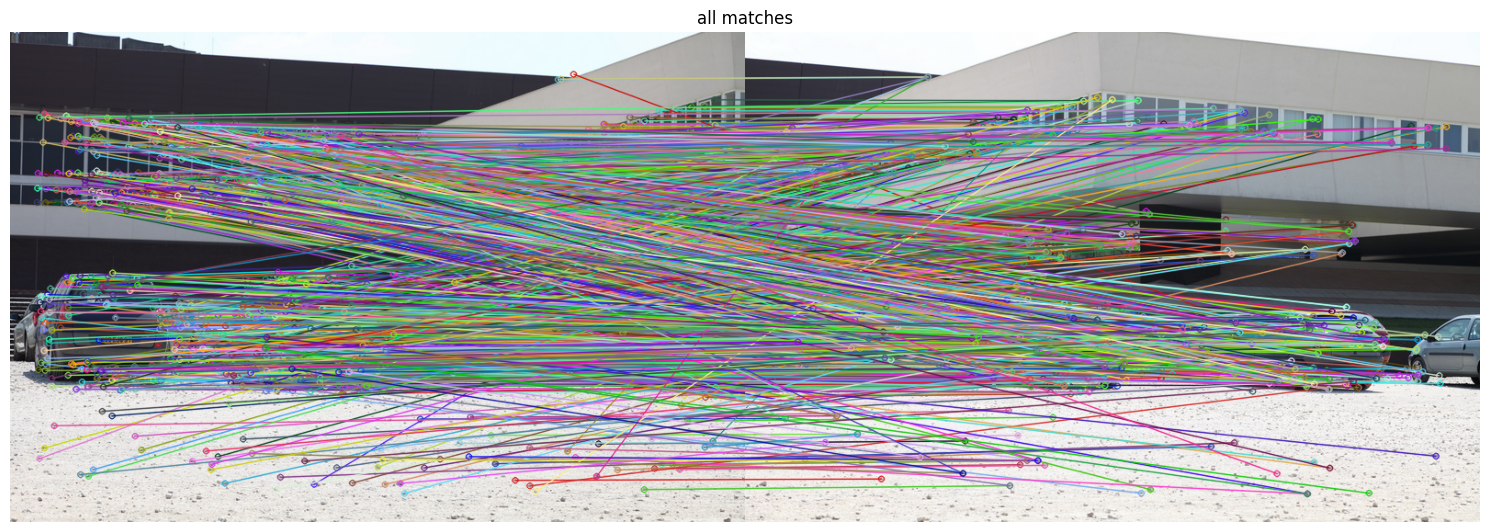

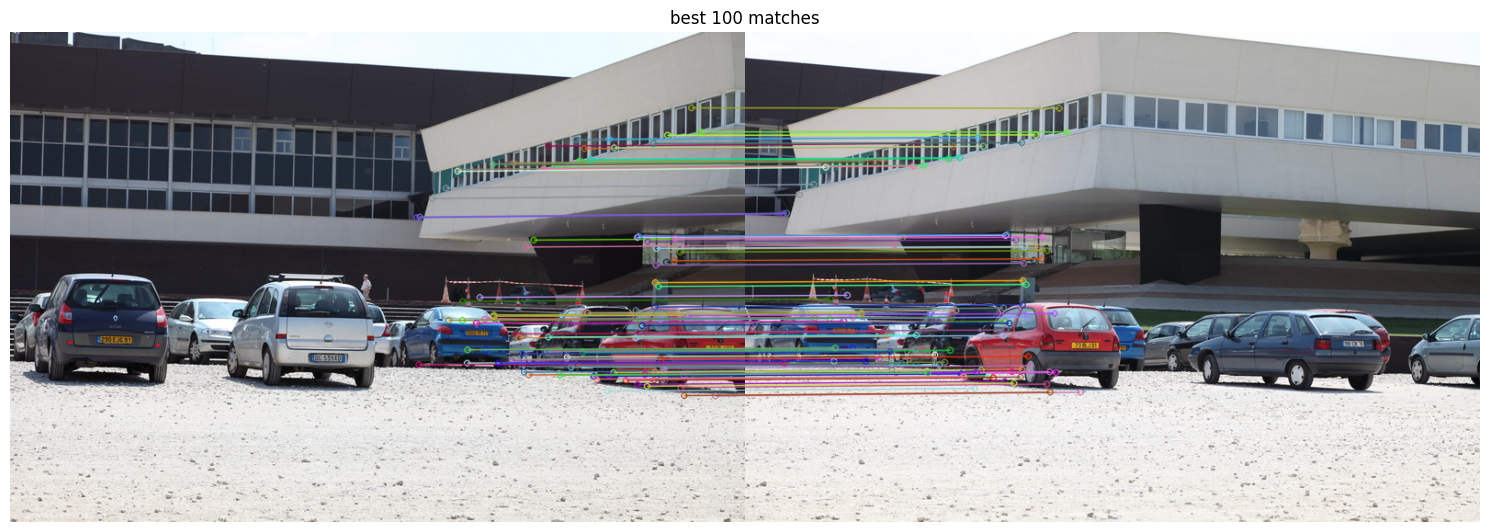

In [12]:
def match_key_points(kp1, des1, kp2, des2):
    # create BFMatcher object
    bf = cv2.BFMatcher()
    # Match descriptors.
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance.
    return sorted(matches, key = lambda x:x.distance)

def showMatches(img1, kp1, img2, kp2, matches, name):
    img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow([img],[name])

matches = match_key_points(kp1, des1, kp2, des2)
showMatches(image1,kp1,image2,kp2,matches,"all matches")
showMatches(image1,kp1,image2,kp2,matches[0:100],"best 100 matches")

# Q3. Homography estimation using RANSAC

Organize the matched feature pairs into a src_pts and a dst_pts array of 2d point coordinates (using keypoint[idx].pt to access the coordinates of keypoint idx, and match.queryIdx and match.trainIdx to access the keypoints idx in image1 and image2 respectively)


cv2.findHomography estimates an homography that transforms the source points into the destination points. This estimation is made robust to outliers using RANSAC.
It also provides a mask of inlier matches. Use this mask to filter out outliers by constructing the list inliers, which is the list of matches that have a value of 1 in the mask.


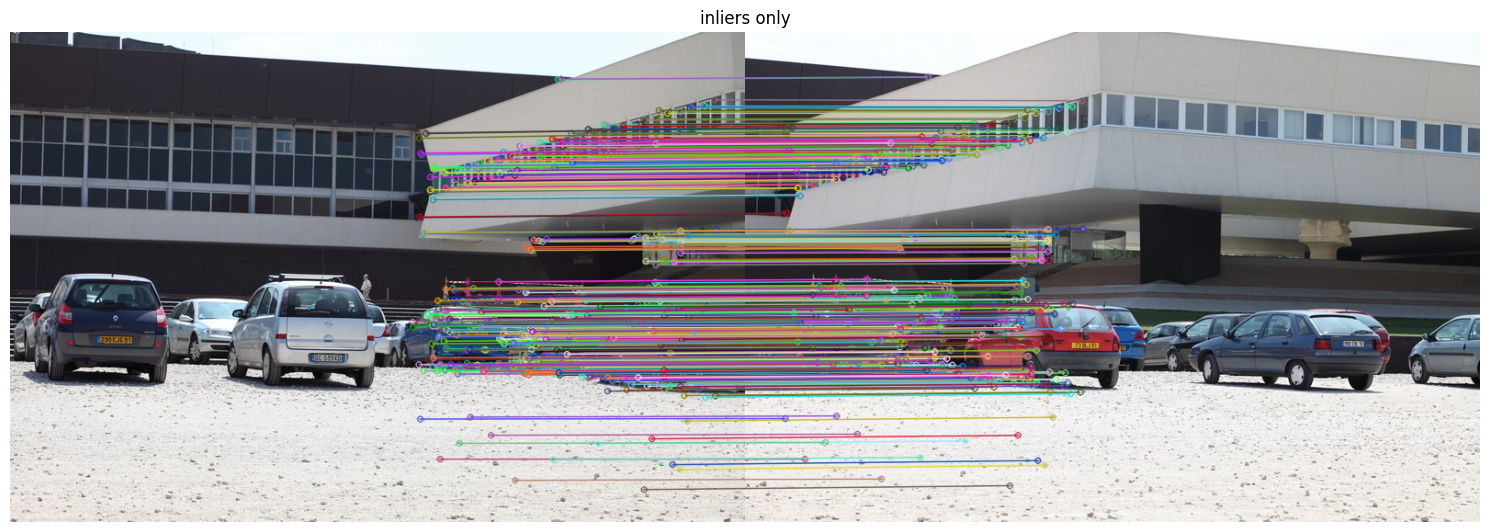

In [13]:
from cv2 import DMatch
from typing import Sequence


def findHomography(matches: Sequence[DMatch], keypoint1, keypoint2):
    src_pts = np.array([keypoint1[match.queryIdx].pt for match in matches])
    dst_pts = np.array([keypoint2[match.trainIdx].pt for match in matches])

    H, mask = cv2.findHomography(src_pts,dst_pts, cv2.RANSAC)
    inliers = [matches[m] for m in range(len(mask)) if mask[m]==1]
    
    return H, inliers

H, inliers = findHomography(matches, kp1, kp2)
showMatches(image1,kp1,image2,kp2,inliers,"inliers only")

# Q4. Image wraping
now that you estimated the homography transform between the images, you can resample them in a common image to stitch a panorama.

A simple approach is to resample image2 in the geometry of image1:
* Create a white image (ie : color = 255, 255, 255) that is twice as wide as image1
* Copy img1 to the (top-)left of this result image, which means an identity transform in terms of pixel coordinates
* Copy img2 to the result image, by warping it with the inverse of the estimated homography (which maps dst_pts to src_pts)

Hint: cv2.warpPerspective has interesting arguments : borderMode enables to keep pixels out of the warped image untouched (otherwise you would lose the previous content of the panorama and only see the last warped image), flags let you specify the interpolation mode (to linear) and let you state that you want to use the inverse of H (using cv2.WARP_INVERSE_MAP)
Hint: copying image1 with an identity transform may be done using indexing of numpy arrays, or using cv2.warpPerspective with an identity 3x3 transform 

Show your panorama ! That should give you a seamless stitching, much better than the translation-based stitching !

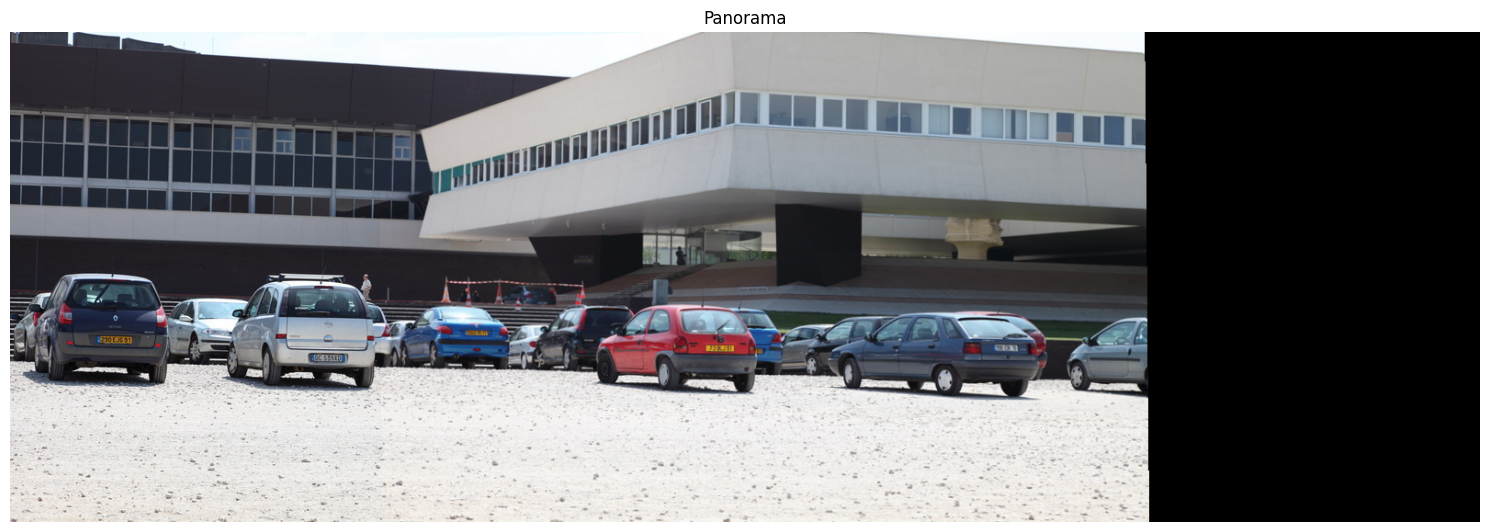

In [38]:
def panorama(img1, img2, H, size):
    
    # img1 and img2 are the two images to be stitched. They are rgb images.

    I = np.ones(size)
    img = np.uint8(I)
    img = cv2.warpPerspective(img1, np.identity(3), size[0:2], borderMode=cv2.BORDER_CONSTANT, dst=img)
    img = cv2.warpPerspective(img2, H, size[0:2], dst=img, borderMode=cv2.BORDER_TRANSPARENT, flags=cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR)
    
    return img

size = (image1.shape[1] * 2, image1.shape[0], 3)

imshow([panorama(image1, image2, H, size)],["Panorama"])


# Q5. Panorama Pipeline and Rotation invariance
Now put all pieces together and right your first end-to-end computer vision pipeline that takes 2 images, the size of the output panorama and create a stitched panorama of the specified size.

Does it work when the images are rotated so that they are not approximately aligned at first or when their brightness change (eg due to varying sun illumination) ?
Make a panorama with modified images :
- the rotated version IMG_0046r.JPG of image IMG_0046.JPG
- a darkened version of image1 : image1//2
Which part of the pipeline is responsible to make this work despite these modifications ?

YOUR ANSWER HERE

In [15]:
def panorama_pipeline(img1, img2, size):
    # YOUR CODE HERE
    raise NotImplementedError()

# size = (???, ???)
# YOUR CODE HERE
raise NotImplementedError()

imshow([panorama_pipeline(image1//2, image2r, size)],["Panorama"])


NotImplementedError: 

# Q6. Make it work on 2 images of your own
Take 2 photos of a flat planar scene and create a panorama with these two photos.


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Q7. Extra credits 1 : Multi Image Panorama
Generate a panorama with more than 2 images.
You can use your own or images from https://github.com/holynski/cse576_sp20_hw5/tree/master/pano 
	

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Q8. Extra credits 2 : Homography Estimation
Write your own version of findHomography assuming inlier matches only, thus no need for robustness to outliers (e.g. with RANSAC)
	

In [ ]:
def findHomography_NonRobust(inliers, keypoint1, keypoint2):
    # src_pts = ???
    # dst_pts = ???
    
    # N = len(???)
    # A = np.zeros(???)

    # for i in range(N):
    #   s = np.array([src_pts[i,0], src_pts[i,1], 1])
    #   d = np.array([dst_pts[i,0], dst_pts[i,1], 1])
    #   A[2*i+0][0:3]= ???
    #   A[2*i+1][3:6]= ???
    #   A[2*i+0][6:9]= ???
    #   A[2*i+1][6:9]= ???
    
    # AtA = ???
    # u, s, vh = np.linalg.svd(???, full_matrices=True)
    # h=vh[???,:].reshape((3,3))
    # return h

    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
def test(matches, title):
    h = findHomography_NonRobust(matches, kp1, kp2)
    imshow([panorama(image1, image2, h, size)],[ title ])

test(inliers, "Panorama with inliers only") # should work
test(matches[0:100], "Panorama with best 100 matches") # should work
test(matches, "Panorama with all matches (including outliers!)") # should not work !
